In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions
from scipy.optimize import minimize
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [448]:
class mlp:
    def __init__(self,hidden_layer_size,batch_size,method='mbatch_gradient',alpha=0.001,Lambda=0.01,num_epochs=100):
        self.details = None
        self.repeat = None
        self.batch_size = batch_size
        self.alpha = alpha
        self.method = method
        self.Lambda=Lambda
        self.num_epochs = num_epochs
        self.hidden_layer_size=hidden_layer_size
        self.layer_graph=None

    def fit(self,x,y):
        y = y.reshape((-1, 1))
        Y = np.zeros((y.shape[0], int(np.max(y, axis=0) + 1)))
        for i in range(0, y.shape[0]):
            Y[i, y[i, 0]] = 1
        layer_graph=[]
        f_number=x.shape[1]
        for i in range(len(self.hidden_layer_size)):
            layer_graph.append(hidden_layer(self.alpha,self.Lambda,self.hidden_layer_size[i],f_number))
            f_number=self.hidden_layer_size[i]
        layer_graph.append(end_layer(self.alpha,self.Lambda,Y.shape[1],f_number))
        self.layer_graph=layer_graph
        result=self.mbatch_gradient_descent(x, Y)
        self.details = result.get('details')
        self.repeat = result.get('repeat')
        print( self.details)
        return self

    def mbatch_gradient_descent(self,x,y):
        jdetails = np.array([])
        jrepeat = np.array([])
        last = self.loss_calculate(x, y)
        nrepeat = 1
        for j in range(0, self.num_epochs):
            index = np.random.choice(x.shape[0], self.batch_size, replace=False)
            x_batch = x[index]
            y_batch = y[index]
            self.error_backpropagation(x_batch,y_batch)
            jdetails = np.hstack((jdetails, np.array([last])))
            jrepeat = np.hstack((jrepeat, np.array([nrepeat])))
            nrepeat += 1
            #///////////////////////////////////just for test
            if j>=2 and jdetails[j]>jdetails[j-1]:
                self.alpha = self.alpha/3
                for t in range(len(self.layer_graph)):
                    self.layer_graph[t].set_alpha(self.alpha)
            #//////////////////////////////////
            last = self.loss_calculate(x, y)
        return {'details': jdetails, 'repeat': jrepeat}

    def loss_calculate(self,x,y):
        h=x
        for i in range(len(self.hidden_layer_size)):
            h=self.layer_graph[i].forward(h)
        h=self.layer_graph[len(self.hidden_layer_size)].cost_function(h,y)
        return h

    def error_backpropagation(self,x,y):
        for i in range(len(self.hidden_layer_size)):
            x=self.layer_graph[i].forward(x)
        h=self.layer_graph[len(self.layer_graph)-1].backward(x,y)
        for i in range(len(self.layer_graph)-2,-1,-1):
            h=self.layer_graph[i].backward(h)

    def predict(self,x):
        for i in range(len(self.layer_graph)):
            x=self.layer_graph[i].forward(x)
        return x

In [449]:
class end_layer:
    def __init__(self,alpha,Lambda,neuron_size,f_number):
        self.w=np.random.rand(f_number,neuron_size)
        self.b=np.random.rand(1,neuron_size)
        self.alpha=alpha
        self.Lambda=Lambda

    def set_alpha(self,alpha):
        self.alpha=alpha

    def backward(self,x, y):
        h = x @ self.w + self.b
        # h = h - np.max(h, axis=1, keepdims=True)
        expH = np.exp(h)
        sumExpH = np.sum(expH, axis=1,keepdims=True)
        prob=expH/sumExpH
        prob[y == 1] = prob[y== 1] - 1
        dw = x.T @ prob
        dx= prob @ self.w.T
        db=prob.sum(axis=0)
        self.w=self.w*(1-self.alpha*self.Lambda)-self.alpha*dw
        self.b = self.b*(1-self.alpha*self.Lambda) - self.alpha *db
        return dx

    def forward(self,x):
        result = x @ self.w + self.b
        return np.argmax(result, axis=1)

    def cost_function(self, x, y):
        h = x@ self.w+ self.b
        expH = np.exp(h)
        sumExpH = np.sum(expH, axis=1, keepdims=True)
        prob = expH / sumExpH
        prob = np.log(prob)
        return -np.sum(y * prob)

In [450]:
class hidden_layer:
    def __init__(self,alpha,Lambda,neuron_size,f_number):
        self.w=np.random.rand(f_number,neuron_size)
        self.b=np.random.rand(1,neuron_size)
        self.alpha=alpha
        self.Lambda=Lambda
        self.x=None

    def set_alpha(self,alpha):
        self.alpha=alpha

    def backward(self,x):
        h = self.x @ self.w + self.b
        # h = h - np.max(h, axis=1, keepdims=True)
        sigmoid=1/(1+np.exp(-h))
        prob=sigmoid*(1-sigmoid)
        prob=x*prob
        dw = self.x.T @ prob
        dx= prob @ self.w.T
        db=prob.sum(axis=0)
        self.w=self.w*(1-self.alpha*self.Lambda)-self.alpha*dw
        self.b = self.b*(1-self.alpha*self.Lambda) - self.alpha *db
        return dx

    def forward(self,x):
        self.x=x
        result = x @ self.w + self.b
        return 1/(1+np.exp(-result))

In [451]:
x,y=make_moons(n_samples=300,noise=0.15,random_state=12)
# x=np.array([[-1.2,1.1],[-1.1,1.3],[2.1,-0.5],[2.2,-0.7]])
# y=np.array([0,0,1,1])

In [476]:
model=mlp((10,),300,num_epochs=1000,alpha=0.01,Lambda=0)

In [477]:
clf=model.fit(x,y)

[ 236.99875803  977.38408635 1270.63818801  589.20119078  171.25390636
  148.0946981   140.5140813   136.16641168  132.55158902  129.28672042
  126.29302323  123.54380993  121.01804254  118.69494866  116.55421815
  114.5766526   112.74458395  111.04207632  109.45496919  107.97081916
  106.57878154  105.2694613   104.03475289  102.8676814   101.76225237
  100.71331417   99.71643451   98.76779144   97.86407816   97.00242069
   96.18030711   95.39552718   94.64612111   93.93033622   93.24659061
   92.5934428    91.96956659   91.37373028   90.80477983   90.26162514
   89.74322922   89.24859955   88.7767815    88.32685329   87.8979223
   87.48912241   87.09961224   86.72857399   86.37521282   86.03875653
   85.71845557   85.41358311   85.12343527   84.84733131   84.58461386
   84.33464903   84.09682652   83.87055955   83.65528484   83.45046232
   83.25557487   83.07012798   82.89364924   82.72568786   82.56581406
   82.41361848   82.26871146   82.13072242   81.99929909   81.87410681
   81.7

In [478]:
n=np.arange(-1.5,2.5,step=0.01)
m=np.arange(-1,1.5,step=0.01)

In [479]:
nn,mm=np.meshgrid(n,m)

In [480]:
nn.shape

(250, 400)

In [481]:
mm.shape

(250, 400)

In [482]:
nv=nn.reshape(-1,1)

In [483]:
mv=mm.reshape(-1,1)

In [484]:
xtest=np.hstack((nv,mv))

In [485]:
z=model.predict(xtest)
z=1/(1+np.exp(-z))
z[z<=0.5]=0
z[z>0.5]=1
z

array([1., 1., 1., ..., 0., 0., 0.])

<ipython-input-486-6a240bad4d12>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(nn,mm,z,cmap=plt.cm.Accent)


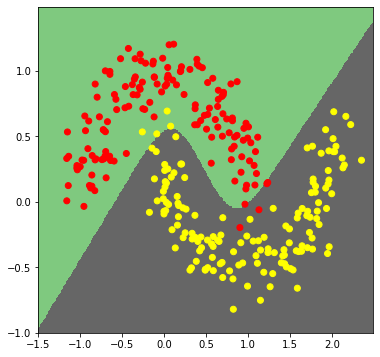

In [486]:
z=z.reshape(nn.shape)
plt.figure(1,figsize=(6,6))
plt.pcolormesh(nn,mm,z,cmap=plt.cm.Accent)
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.autumn)